In [1]:
# import libriaries 
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import json
import psycopg2
import sqlalchemy

In [2]:
# create direct connection to our database
from sqlalchemy import create_engine
# Postgres username, password and database name 
POSTGRES_ADDRESS = 'localhost' # insert address name 
POSTGRES_PORT = '5432'
POSTGRES_USERNAME = 'postgres'
POSTGRES_PASSWORD = 'd3coded'
# A long string that contains the necessary Postrgess details
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'.format(username=POSTGRES_USERNAME,password=POSTGRES_PASSWORD, ipaddress= POSTGRES_ADDRESS, port = POSTGRES_PORT, dbname='decodeddatabase'))
# create connection
cnx= create_engine(postgres_str)

In [16]:
Loans = pd.read_sql_query('''SELECT de.a2 as district,
case sum(
            case loans.status
            when 'B' then 1
            else 0
        end)
        when 0 then 0
        else
            cast (sum (case loans.status
            when 'B' then 1
            else 0
        end) as numeric)/
            cast (sum (case loan.status
            when 'B' then 1
            when 'A' then 1
            else 0
        end) as numeric)
    end as default_rate
FROM loans LEFT JOIN accounts acc on acc.account_id = loans.account_id LEFT JOIN demographics de on acc.district_id = de.district_id
GROUP BY district ORDER BY default_rate desc''', cnx)

ProgrammingError: (psycopg2.errors.UndefinedTable) missing FROM-clause entry for table "loan"
LINE 13:             cast (sum (case loan.status
                                     ^
 [SQL: "SELECT de.a2 as district,\ncase sum(\n            case loans.status\n            when 'B' then 1\n            else 0\n        end)\n        when 0 then 0\n        else\n            cast (sum (case loans.status\n            when 'B' then 1\n            else 0\n        end) as numeric)/\n            cast (sum (case loan.status\n            when 'B' then 1\n            when 'A' then 1\n            else 0\n        end) as numeric)\n    end as default_rate\nFROM loans LEFT JOIN accounts acc on acc.account_id = loans.account_id LEFT JOIN demographics de on acc.district_id = de.district_id\nGROUP BY district ORDER BY default_rate desc"] (Background on this error at: http://sqlalche.me/e/f405)

In [4]:
Excel_backup= pd.read_csv('Credit_data_Hackathon4.csv')

In [6]:
Loans_data = pd.read_sql_query('''SELECT accounts.account_id, loans.amount, loans.duration, loans.payments, loans.status, demographics.a2, clients.gender, clients.birth_date, dispositions.type  FROM loans
LEFT JOIN accounts on loans.account_id = accounts.account_id
LEFT JOIN demographics on accounts.district_id = demographics.district_id
LEFT JOIN dispositions on accounts.account_id = dispositions.account_id
LEFT JOIN clients on dispositions.client_id = clients.client_id''', cnx)

In [7]:
Loans_data.sample(5)

,account_id,amount,duration,payments,status,a2,gender,birth_date,type
716,9859,300600,60,5010.0,C,Plzen - jih,F,1964-06-26,OWNER
775,10679,197808,24,8242.0,C,Hl.m. Praha,F,1962-11-03,OWNER
19,290,123696,48,2577.0,A,Breclav,M,1940-08-27,OWNER
671,9353,188616,24,7859.0,C,Kromeriz,F,1940-05-21,DISPONENT
515,7594,130464,48,2718.0,C,Jindrichuv Hradec,M,1974-03-22,OWNER


In [8]:
#Loans_data['amount'].groupby(Loans_data['a2']).describe()
#Loans_data['a2'].groupby([Loans_data['a2'],Loans_data['gender'], Loans_data['status']]).count()

In [20]:
Loans_statusdata= pd.get_dummies(Loans_data, columns=['status', 'gender', 'type'])
Loans_statusdata.head(2)

,account_id,amount,duration,payments,a2,birth_date,status_A,status_B,status_C,status_D,gender_F,gender_M,type_DISPONENT,type_OWNER
0,2,80952,24,3373.0,Hl.m. Praha,1945-02-04,1,0,0,0,0,1,0,1
1,2,80952,24,3373.0,Hl.m. Praha,1940-10-09,1,0,0,0,1,0,1,0


In [28]:
Total_district_loans = pd.pivot_table(Loans_statusdata,index=["a2"],values=["status_A","status_B","status_C","status_D"])
Total_district_loans.head(2)

,status_A,status_B,status_C,status_D
a2,,,,
Benesov,0.142857,0.0,0.857143,0.000000
Beroun,0.285714,0.0,0.428571,0.285714


In [34]:
df2 = Total_district_loans['status_A'] + Total_district_loans['status_C']
df3 = Total_district_loans['status_B'] + Total_district_loans['status_D']
Total_district_loansFinal = pd.DataFrame([df2,df3],index=['Good','Default_rate']).transpose()
Total_district_loansFinal.head(2)

,Good,Default_rate
a2,,
Benesov,1.000000,0.000000
Beroun,0.714286,0.285714


In [35]:
sorted_Total_district_loansFinal = Total_district_loansFinal.sort_values(by='Default_rate', ascending=False)
sorted_Total_district_loansFinal.head(10)

,Good,Default_rate
a2,,
Domazlice,0.500000,0.500000
Sokolov,0.500000,0.500000
Strakonice,0.500000,0.500000
Bruntal,0.500000,0.500000
Opava,0.666667,0.333333
Kutna Hora,0.700000,0.300000
Beroun,0.714286,0.285714
Klatovy,0.750000,0.250000
Tabor,0.750000,0.250000


In [9]:
Loans_district = pd.pivot_table(Loans_data,index=["a2","status"],values=["amount"])
Loans_district.reset_index(inplace=True)
Loans_district.a2.ffill(inplace=True)
Loans_district.head(10)

,a2,status,amount
0,Benesov,A,107640.0
1,Benesov,C,145700.0
2,Beroun,A,19248.0
3,Beroun,C,304624.0
4,Beroun,D,263838.0
5,Blansko,A,42795.0
6,Blansko,C,228123.0
7,Blansko,D,307200.0
8,Breclav,A,123696.0
9,Breclav,B,276660.0


In [10]:
# Total loan count per branch
Total_district_loans = pd.pivot_table(Loans_data,index=["a2"],values=["status"], aggfunc='count')
Total_district_loans.reset_index(inplace=True)
Total_district_loans.head()

,a2,status
0,Benesov,7
1,Beroun,7
2,Blansko,9
3,Breclav,7
4,Brno - mesto,29


In [39]:
Total_district_loans.rename(columns = {'a2':'district'})
Total_district_loans.head(2)

,status_A,status_B,status_C,status_D
a2,,,,
Benesov,0.142857,0.0,0.857143,0.000000
Beroun,0.285714,0.0,0.428571,0.285714


In [40]:
Loans_districtCount = pd.pivot_table(Loans_data,index=["a2","status"],values=["account_id"], aggfunc='count')
Loans_districtCount.reset_index(inplace=True)
Loans_districtCount.a2.ffill(inplace=True)
Loans_districtCount.head()

,a2,status,account_id
0,Benesov,A,1
1,Benesov,C,6
2,Beroun,A,2
3,Beroun,C,3
4,Beroun,D,2


In [41]:
# including the loan count 
Loans_district['loan_count'] = Loans_districtCount["account_id"].values

In [42]:
# renaming the district
Loans_district.rename(columns = {'a2':'district'})
Loans_district.head(2)

,a2,status,amount,loan_count
0,Benesov,A,107640.0,1
1,Benesov,C,145700.0,6


In [46]:
#sorted_Total_district_loansFinal['amount','loan_count']= Loans_district["amount", "loan_count"]

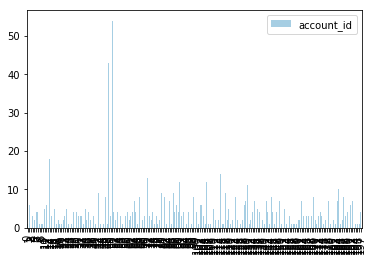

In [44]:
Loans_districtCount.plot(kind='bar', stacked=True, colormap='Paired')